# Welcome to the NoisePy SCEDC Tutorial!

Noisepy is a python software package to process ambient seismic noise cross correlations. 

**Publication about this software**:
Chengxin Jiang, Marine A. Denolle; NoisePy: A New High‐Performance Python Tool for Ambient‐Noise Seismology. Seismological Research Letters 2020; 91 (3): 1853–1866. doi: https://doi.org/10.1785/0220190364



This tutorial will walk you through the basic steps of using NoisePy to compute ambient noise cross correlation functions using single instance workflow.

The data is stored on AWS S3 as the SCEDC Data Set: https://scedc.caltech.edu/data/getstarted-pds.html



First, we install the noisepy-seis package

In [ ]:
! pip install noisepy-seis --upgrade

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. Restart the runtime now for proper installation of ```obspy``` on Colab.

This tutorial should be ran after installing the noisepy package. 

## Import necessary modules

Then we import the basic modules

In [1]:
from noisepy.seis import cross_correlate, stack, plotting_modules       # noisepy core functions
from noisepy.seis.asdfstore import ASDFCCStore                          # Object to store ASDF data within noisepy
from noisepy.seis.scedc_s3store import SCEDCS3DataStore, channel_filter # Object to query SCEDC data from on S3
from noisepy.seis.pnwstore import PNWDataStore, channel_filter
from noisepy.seis.datatypes import ConfigParameters, Channel, ChannelData, ChannelType, Station    # Main configuration object
from noisepy.seis.channelcatalog import XMLStationChannelCatalog        # Required stationXML handling object
import os
import glob
import obspy
from datetime import datetime
from datetimerange import DateTimeRange


path = "./scedc_data" 

os.makedirs(path, exist_ok=True)
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")

/home/niyiyu/anaconda3/envs/noisepy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# SCEDC S3 bucket common URL characters for that day.
S3_STATION_XML = "/1-fnp/pnwstore1/p-wd11/PNWStationXML/UW"            # S3 storage of stationXML
S3_DATA = "/1-fnp/pnwstore1/p-wd00/PNW2020/UW/"
# timeframe for analysis
start = datetime(2020, 1, 2)
end = datetime(2020, 1, 4)
range = DateTimeRange(start, end)
print(range)

2020-01-02T00:00:00 - 2020-01-04T00:00:00


We will work with a single day worth of data on SCEDC. The continuous data is organized with a single day and channel per miniseed (https://scedc.caltech.edu/data/cloud.html). For this example, you can choose any year since 2002. We will just cross correlate a single day.

The station information, including the instrumental response, is stored as stationXML in the following bucket

## Ambient Noise Project Configuration

We store the metadata information about the ambient noise cross correlation workflow in a ConfigParameters() object. We first initialize it, then we tune the parameters for this cross correlation.

In [3]:
# Initialize ambient noise workflow configuration
config = ConfigParameters() # default config parameters which can be customized

Customize the job parameters below:

In [4]:

config.samp_freq= 20  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 3600.0  # (float) basic unit of data length for fft (sec)
    # criteria for data selection
config.ncomp = 3  # 1 or 3 component data (needed to decide whether do rotation)


config.acorr_only = False  # only perform auto-correlation or not
config.xcorr_only = True  # only perform cross-correlation or not

# config.inc_hours = 24 # if the data is first 

 # pre-processing parameters
config.step= 1800.0  # (float) overlapping between each cc_len (sec)
config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
config.rm_resp= "inv"  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',
config.freqmin = 0.05
config.freqmax = 2.0
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# TEMPORAL and SPECTRAL NORMALISATION
config.freq_norm= "rma"  # choose between "rma" for a soft whitenning or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)

config.time_norm = "no"  # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
    # TODO: change time_norm option from "no" to "None"
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)

config.cc_method= "xcorr"  # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

# OUTPUTS:
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations

config.maxlag= 200  # lags of cross-correlation to save (sec)
config.substack = True

In [5]:
# For this tutorial make sure the previous run is empty
os.system(f"rm -rf {cc_data_path}")

0

## Step 1: Cross-correlation



In [22]:
stations = "BBO,BABR".split(",") # filter to these stations
catalog = XMLStationChannelCatalog(S3_STATION_XML)
raw_store = PNWDataStore(S3_DATA, catalog, channel_filter(stations, "HH"), date_range=range) # Store for reading raw data from S3 bucket
cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data
# print the configuration parameters. Some are chosen by default but we can modify them
# print(config)

In [23]:
raw_store.channels

{'2020-01-02T00:00:00+0000 - 2020-01-03T00:00:00+0000': [UW.BABR.HHE,
  UW.BABR.HHN,
  UW.BABR.HHZ,
  UW.BBO.HHE,
  UW.BBO.HHN,
  UW.BBO.HHZ],
 '2020-01-03T00:00:00+0000 - 2020-01-04T00:00:00+0000': [UW.BABR.HHE,
  UW.BABR.HHN,
  UW.BABR.HHZ,
  UW.BBO.HHE,
  UW.BBO.HHN,
  UW.BBO.HHZ]}

Perform the cross correlation
Here, removing the instrumental response is slow. It could also be the interpolation

In [24]:
cross_correlate(raw_store, config, cc_store)

2023-06-05 08:37:47,347	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-06-05 08:37:48,308 INFO utils log TIMING: 2.7760 for Ray init
2023-06-05 08:37:48,309 INFO S1_fft_cc_MPI cross_correlate 127.0.0.1:8265
2023-06-05 08:37:48,312 INFO asdfstore _get_dataset_cached ASDFCCStore - Opening ./scedc_data/CCF/2020_01_02_00_00_00T2020_01_03_00_00_00.h5
2023-06-05 08:37:48,315 INFO utils log TIMING: 0.0000 for get channels
2023-06-05 08:37:52,630 INFO S1_fft_cc_MPI _filter_channel_data Picked 100.0 as the closest sampling frequence to 20. Filtered to 6/6 channels
2023-06-05 08:37:52,631 INFO utils log TIMING: 4.3155 for read channel data
(preprocess_ray pid=3654483) 2023-06-05 08:37:53,655 INFO noise_module preprocess_raw removing response for UW.BABR..HHZ | 2020-01-02T00:00:00.000000Z - 2020-01-02T23:59:59.950000Z | 20.0 Hz, 1728000 samples using inv
(preprocess_ray pid=3654486) 2023-06-05 08:37:53,709 INFO noise_module preprocess_raw removing 

Plot a single set of the cross correlation

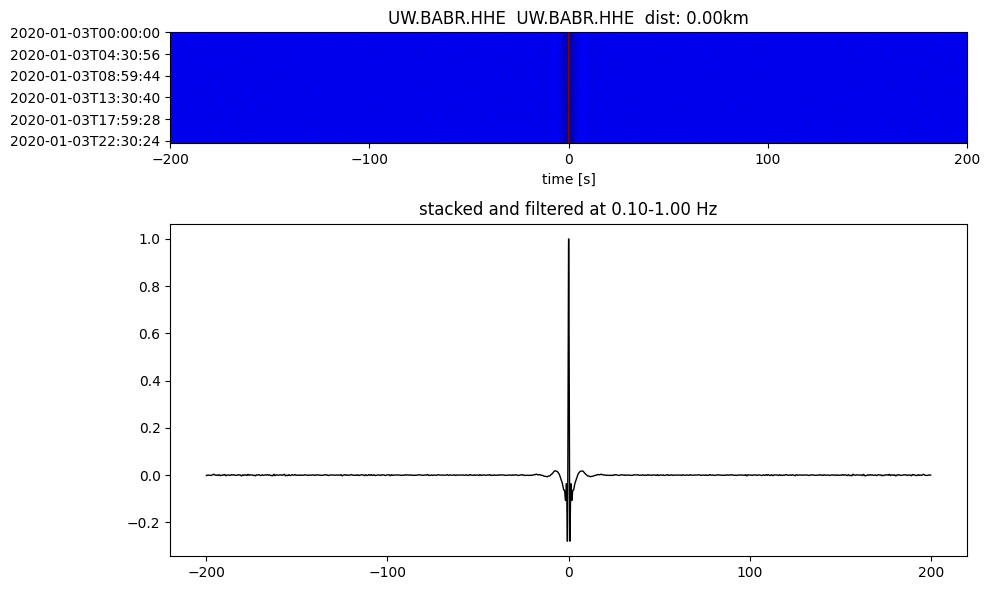

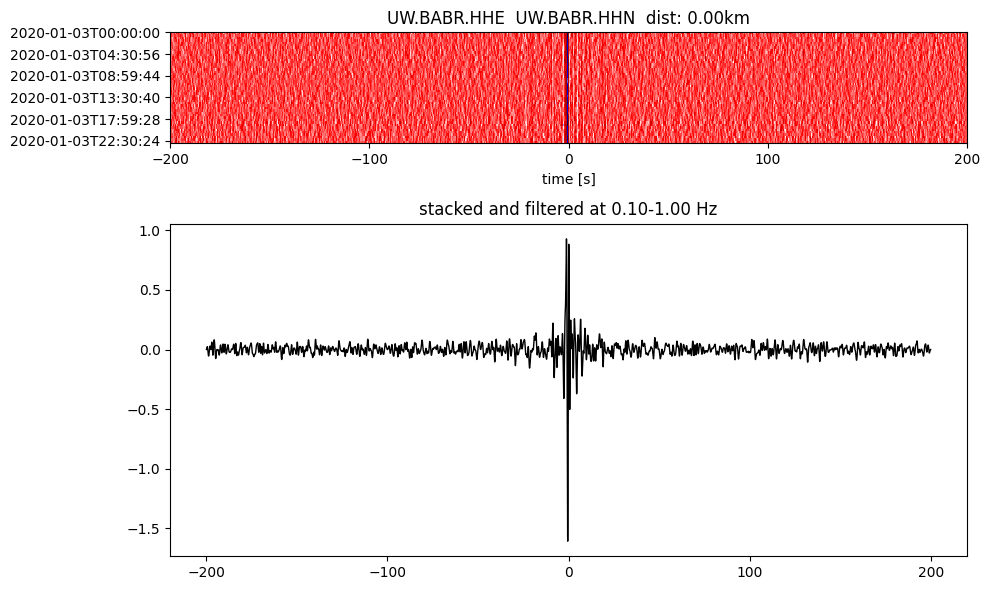

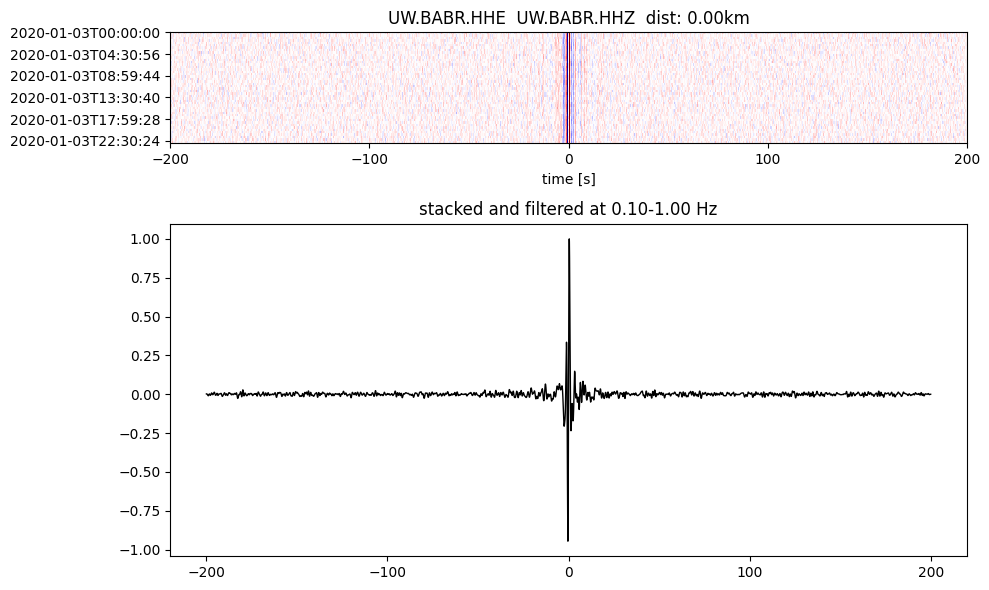

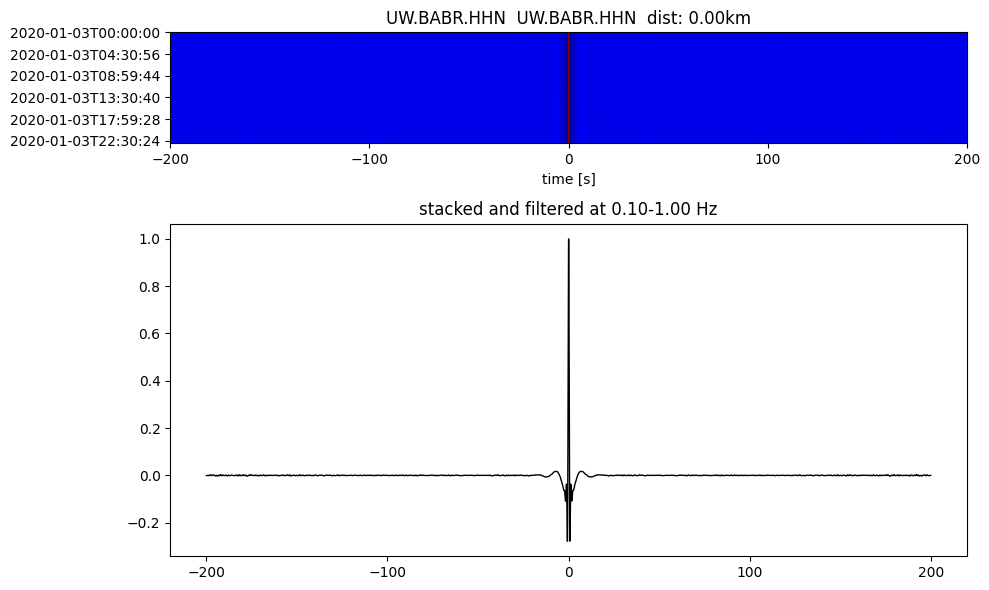

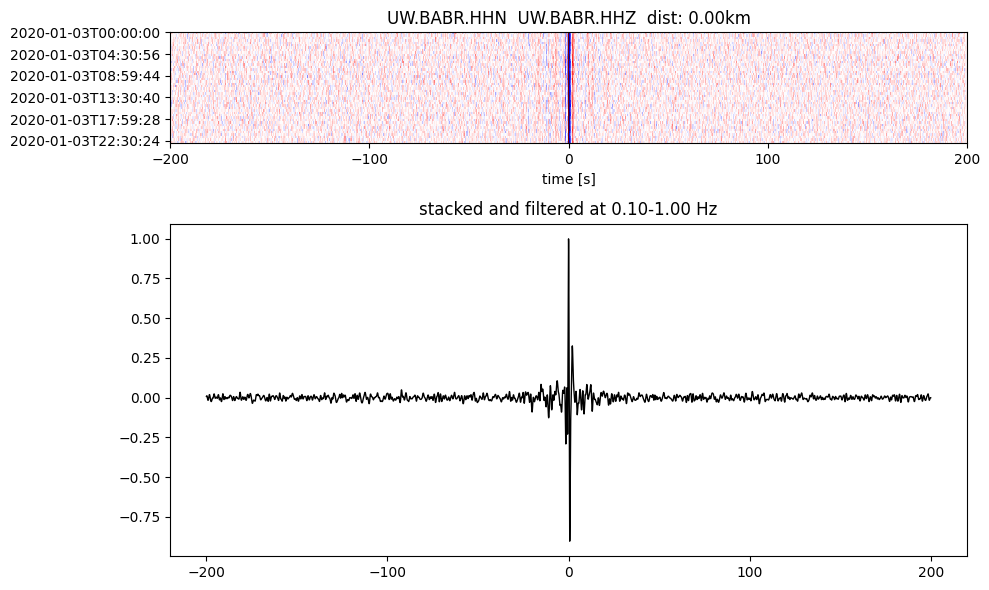

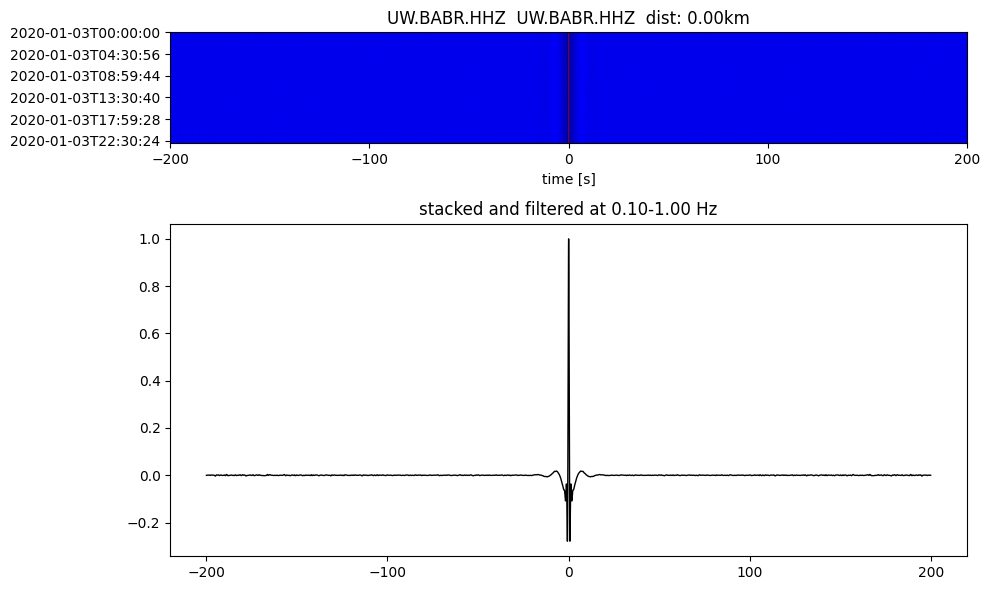

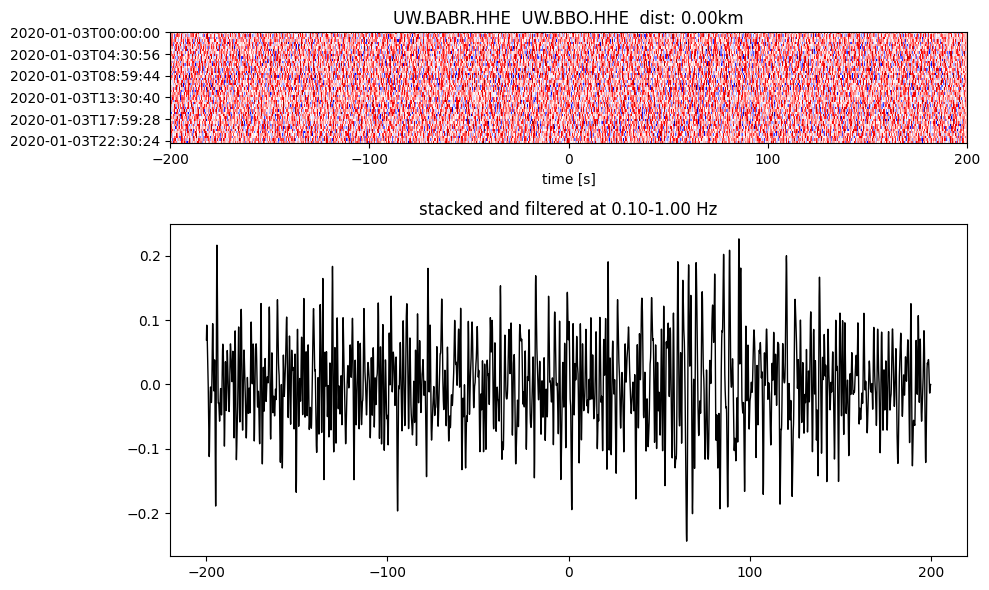

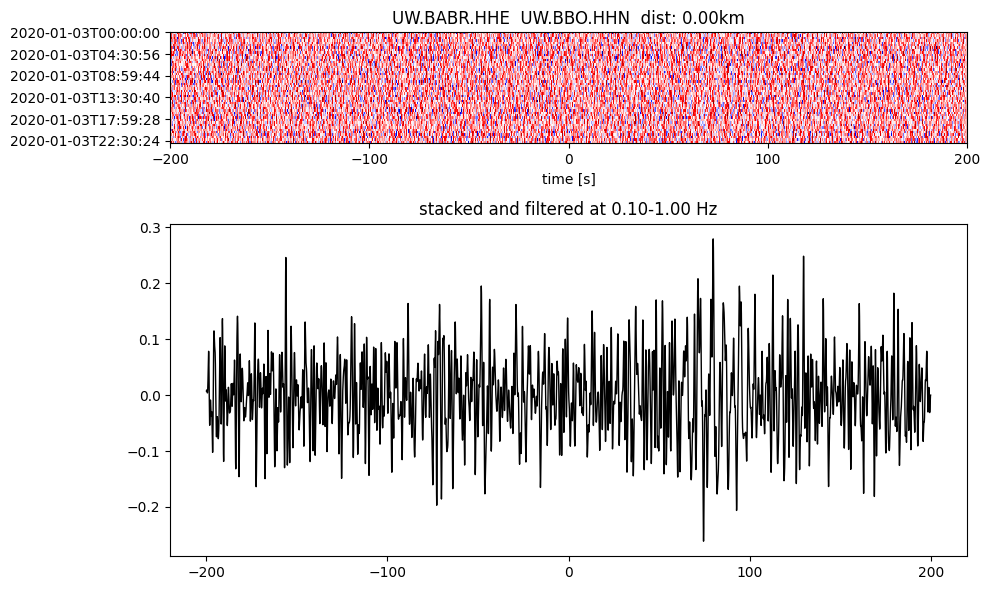

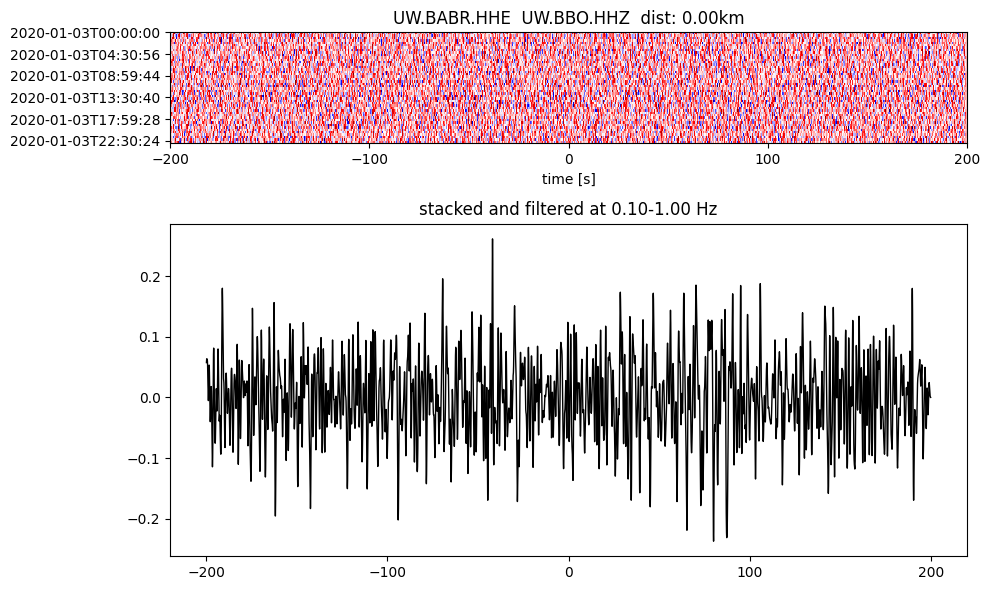

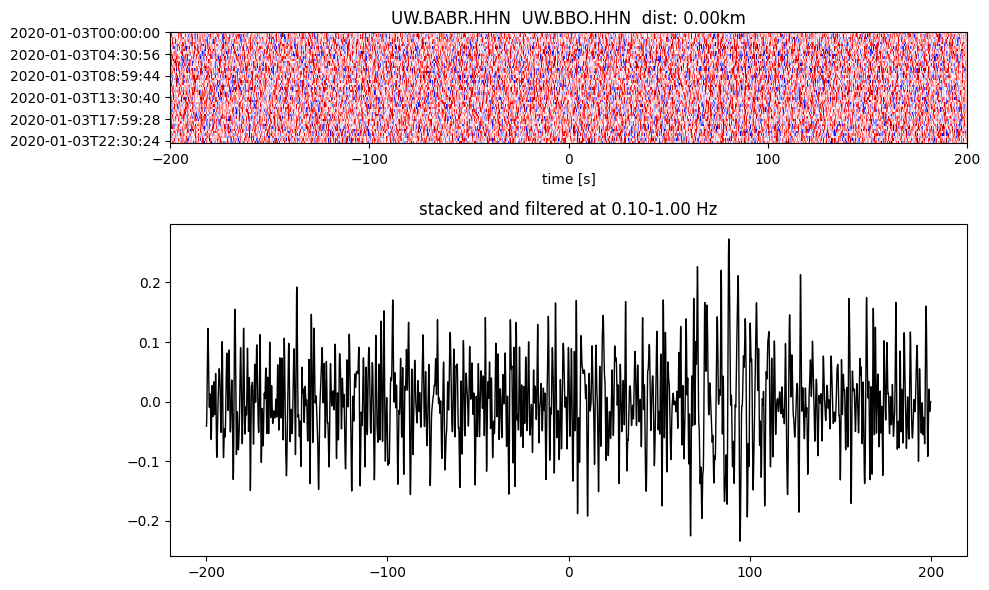

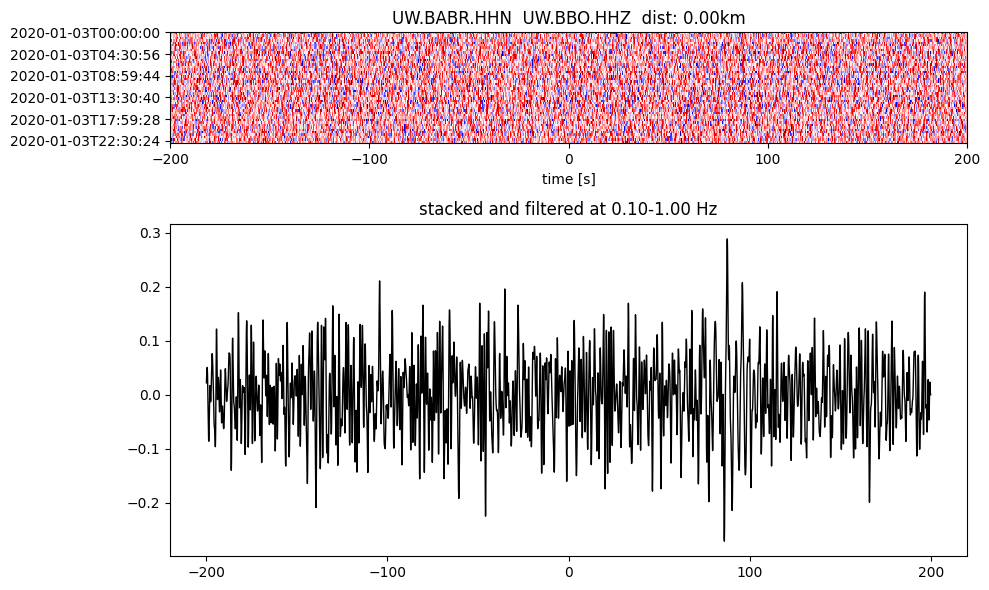

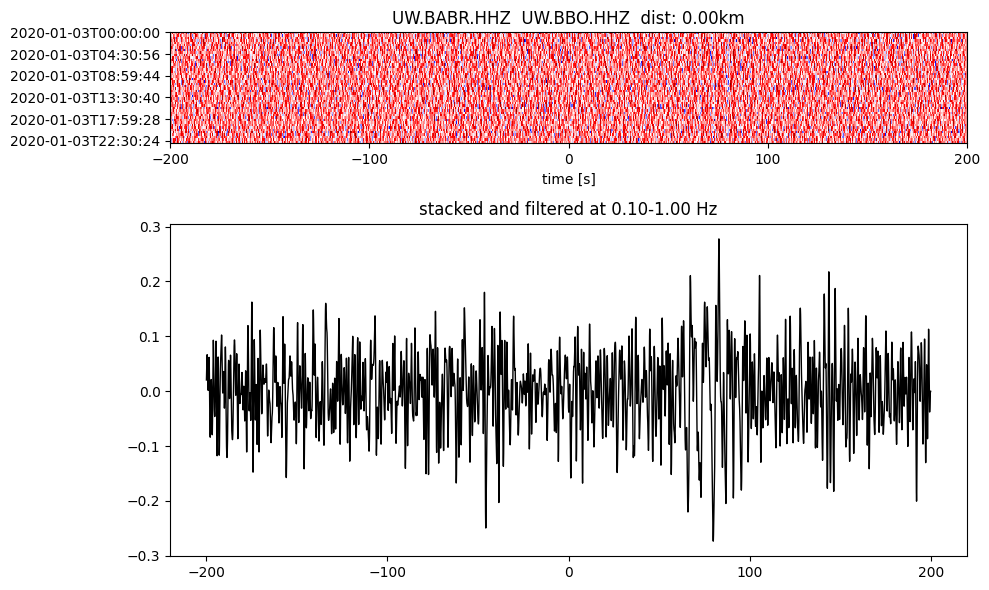

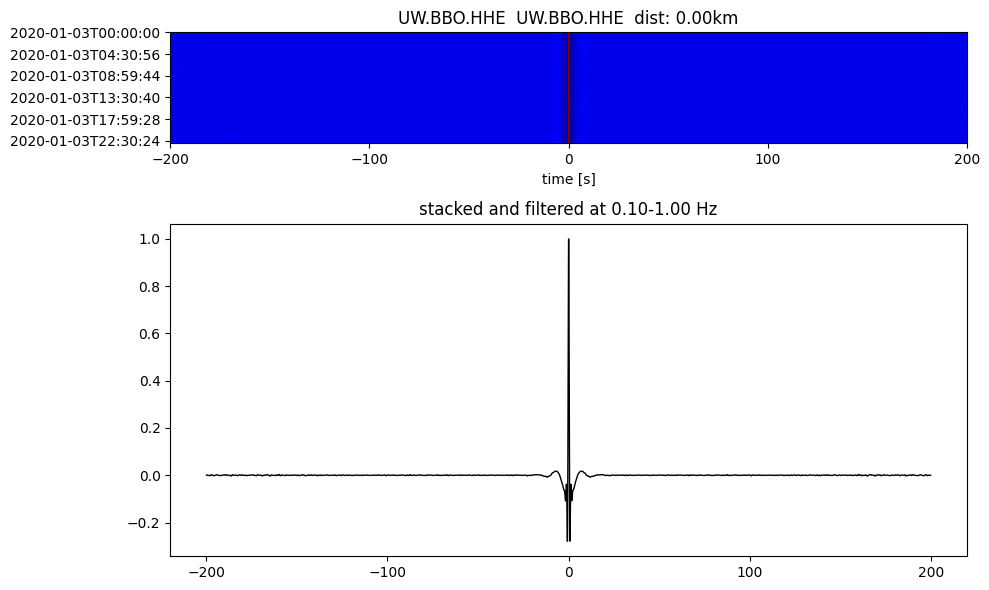

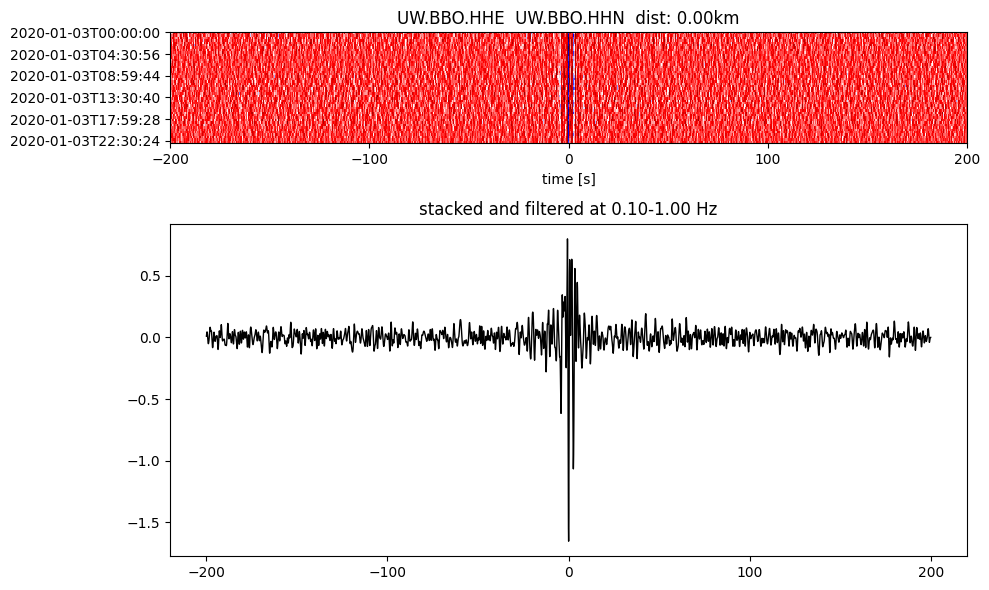

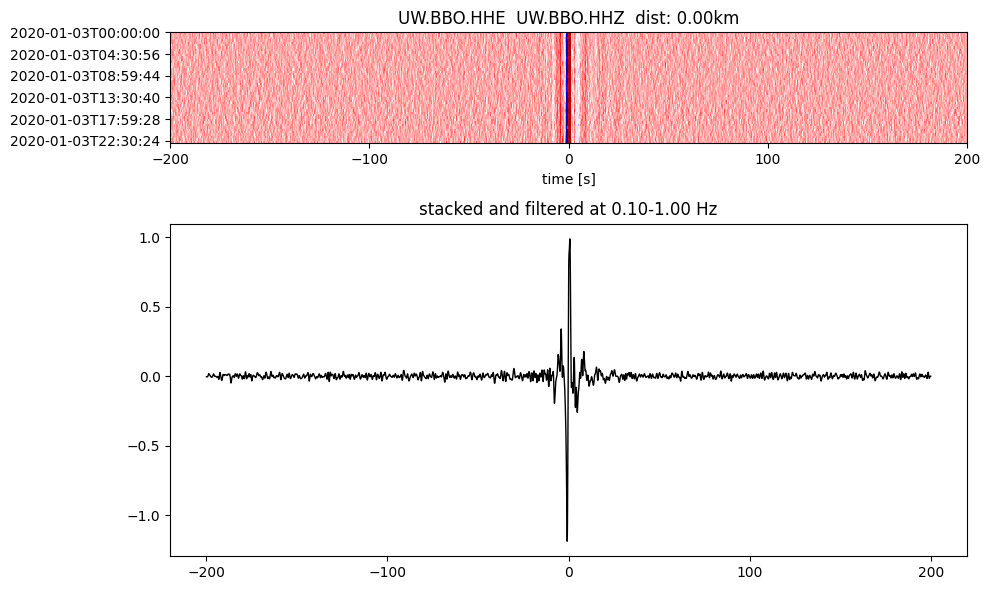

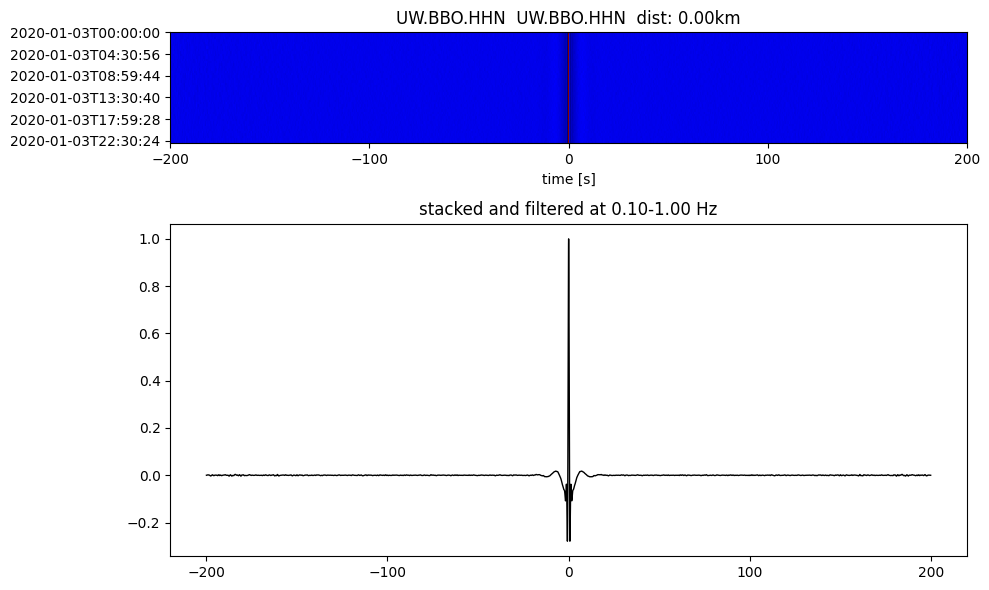

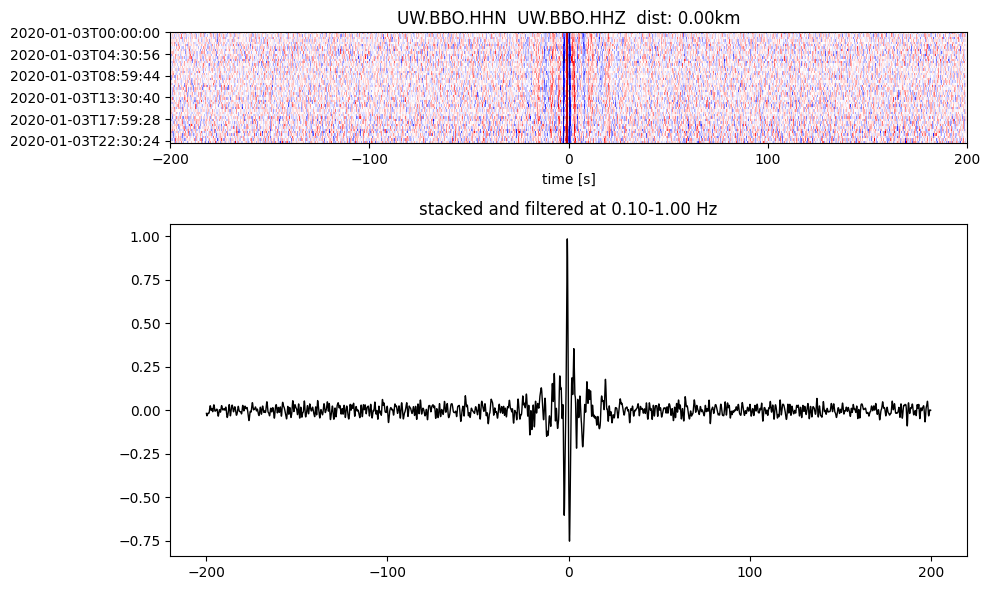

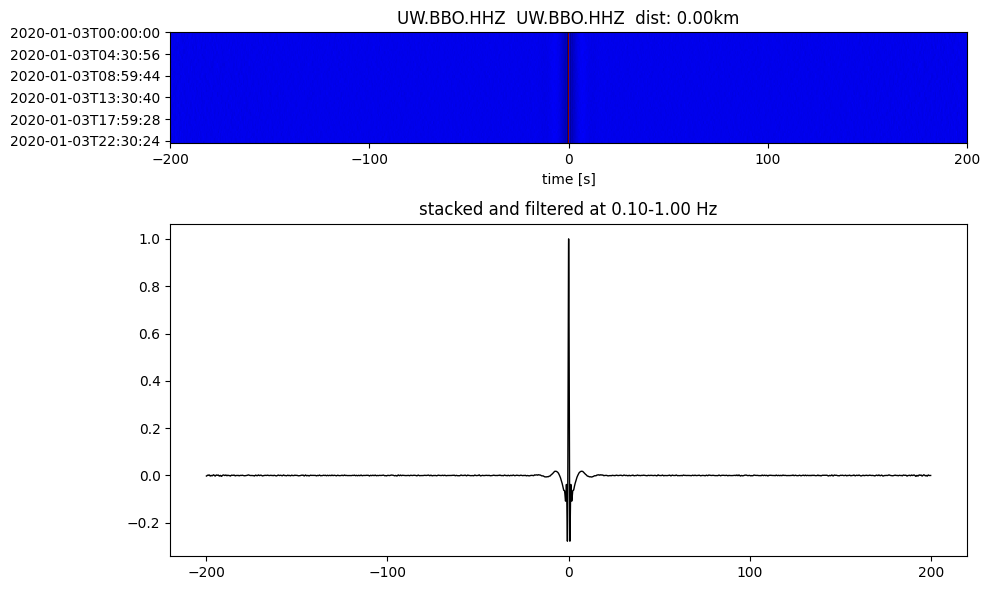

In [5]:
file = os.path.join(cc_data_path, '2020_01_03_00_00_00T2020_01_04_00_00_00.h5')
plotting_modules.plot_substack_cc(file,0.1,1,None,False)

## Step 3: Stack the cross correlation

STILL NEEDS TO BE FIXED

Provide a path to where the data is.

In [ ]:
stack(cc_store, stack_data_path, config)

Plot the stacks

In [ ]:
print(os.listdir(cc_data_path))
print(os.listdir(stack_data_path))

In [ ]:
files = glob.glob(os.path.join(stack_data_path, '**/*.h5'))
print(files)
plotting_modules.plot_all_moveout(files, 'Allstack_linear', 0.1, 0.2, 'ZZ', 1)